### Section 1: Import Data and Settings

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = './'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [5]:
def aggregate_diagnostic(y_dic):
    tmp = []
   #Y
   #  print(y_dic.keys())
    for key in y_dic.keys():
        if key in agg_df.index:
            #print("key", key)
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [6]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### Section 2: Preprocessing

In [7]:
# variable to remove/set class balancing Section 2.2
balanced =False

#### Section 2.1 Train and Test Split Without any Preprocessing

In [8]:
def split(X, Y):
    test_fold = 10
    # Train
    X_train = X[np.where(Y.strat_fold != test_fold)]
    y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
    # Test
    X_test = X[np.where(Y.strat_fold == test_fold)]
    y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test=split(X, Y)
y_train.shape
X_train.shape

(19601, 5000, 12)

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer

def encode_filter(X_train, y_train, X_test, y_test, permute, oned):
    # Create label encoding
    unique_classes = list(set([item for sublist in y_train for item in sublist]))
    class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}

    # Filter out data with no labels in y_train and y_test
    y_train_filtered = [labels for labels in y_train if labels]  # Keeps only non-empty labels
    X_train_filtered = X_train[np.array([bool(labels) for labels in y_train])]  # Matches X_train to non-empty labels in y_train

    y_test_filtered = [labels for labels in y_test if labels]  # Keeps only non-empty labels
    X_test_filtered = X_test[np.array([bool(labels) for labels in y_test])]  # Matches X_test to non-empty labels in y_test

    # Re-encode the filtered y_train and y_test
    y_train_encoded = [class_to_idx[labels[0]] for labels in y_train_filtered]
    y_test_encoded = [class_to_idx[labels[0]] for labels in y_test_filtered]

    # Convert filtered X to tensors 
    if permute:
        X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32).unsqueeze(1).permute(0, 3, 2, 1)
        X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32).unsqueeze(1).permute(0, 3, 2, 1)
    else:
        X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32)
    if oned:
        X_train_tensor=X_train_tensor.squeeze(dim=3)
        X_test_tensor=X_test_tensor.squeeze(dim=3)

    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
    print("X_train_tensor shape", X_train_tensor.shape)
    print("X_test_tensor shape", X_test_tensor.shape)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_loader, test_loader, y_train_encoded, y_test_encoded, y_train_tensor, X_train_filtered, X_train_tensor, X_test_filtered

In [10]:
train_loader, test_loader, y_train_encoded, y_test_encoded, y_train_tensor, X_train_filtered, X_train_tensor, X_test_filtered=encode_filter(X_train, y_train,  X_test, y_test, permute=True,oned=False)

X_train_tensor shape torch.Size([19230, 12, 5000, 1])
X_test_tensor shape torch.Size([2158, 12, 5000, 1])


In [11]:
train_loader_1d, test_loader_1d, y_train_encoded, y_test_encoded, y_train_tensor, X_train_filtered_1d, X_train_tensor_1d, X_test_filtered_1d=encode_filter(X_train, y_train,  X_test, y_test, permute=True, oned=True)

X_train_tensor shape torch.Size([19230, 12, 5000])
X_test_tensor shape torch.Size([2158, 12, 5000])


In [ ]:
num_classes=len(y_train_tensor.unique())

#### Section 2.2 Handling Class Imbalance

In [39]:
from sklearn.utils import resample

def undersample_data(X, Y):
    df = pd.DataFrame({'class': Y['diagnostic_superclass'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'), 'index': np.arange(len(Y))})
    grouped = df.groupby('class')
    min_size = grouped.size().min()  # Size of the smallest class

    indices = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)['index']
    indices = indices.values

    return X[indices], Y.iloc[indices]

X_balanced, Y_balanced = undersample_data(X, Y)
print(f"Shape of a balanced data: {X_balanced.shape}")


Shape of a balanced data: (2466, 5000, 12)


/tmp/ipykernel_811277/3953435631.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)['index']


#### Section 2.3 Artifact Removal

In [40]:
from scipy.signal import butter, filtfilt

def remove_powerline_noise(signal, fs=500, freq=50, Q=30):
    """
    Removes powerline noise using a Notch filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - freq: Frequency to be removed (50 or 60 Hz).
    - Q: Quality factor for the notch filter.
    
    Returns:
    - filtered_signal: Signal with powerline noise removed.
    """
    from scipy.signal import iirnotch

    nyquist = 0.5 * fs
    w0 = freq / nyquist  # Normalize frequency
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [42]:

def remove_baseline_wander(signal, fs=500, cutoff=0.5):
    """
    Removes baseline wander using a high-pass filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - cutoff: Cutoff frequency for the high-pass filter.
    
    Returns:
    - filtered_signal: Signal with baseline wander removed.
    """
    nyquist = 0.5 * fs
    b, a = butter(1, cutoff / nyquist, btype='high')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


In [43]:
def remove_high_frequency_noise(signal, fs=500, cutoff=40):
    """
    Removes high-frequency noise using a low-pass filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - cutoff: Cutoff frequency for the low-pass filter.
    
    Returns:
    - filtered_signal: Signal with high-frequency noise removed.
    """
    nyquist = 0.5 * fs
    b, a = butter(1, cutoff / nyquist, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [44]:
def clean_ecg_data(X, fs=500):
    """
    Cleans a 3D ECG dataset (samples, time steps, leads) by removing artifacts.
    
    Args:
    - X: 3D array of shape (num_samples, signal_length, 12).
    - fs: Sampling frequency.
    
    Returns:
    - X_clean: 3D array of cleaned ECG data.
    """
    num_samples, signal_length, num_leads = X.shape
    X_clean = np.zeros_like(X)

    for sample_idx in range(num_samples):
        if sample_idx%1000==0:
            print("Sample_index:", sample_idx)
        for lead_idx in range(num_leads):
            signal = X[sample_idx, :, lead_idx]
            
            # Remove baseline wander
            signal = remove_baseline_wander(signal, fs=fs)
            # Remove powerline noise
            signal = remove_powerline_noise(signal, fs=fs, freq=50)  # Use 60 Hz for US data
            # Remove high-frequency noise
            signal = remove_high_frequency_noise(signal, fs=fs)

            # Store cleaned signal
            X_clean[sample_idx, :, lead_idx] = signal

    return X_clean


In [45]:
# clean the data
if balanced:
    X_cleaned = clean_ecg_data(X_balanced, fs=sampling_rate)
else:
    X_cleaned = clean_ecg_data(X, fs=sampling_rate)

if balanced:
    Y_cleaned=Y_balanced.copy()
else:
    Y_cleaned=Y.copy()


Sample_index: 0
Sample_index: 1000
Sample_index: 2000
Sample_index: 3000
Sample_index: 4000
Sample_index: 5000
Sample_index: 6000
Sample_index: 7000
Sample_index: 8000
Sample_index: 9000
Sample_index: 10000
Sample_index: 11000
Sample_index: 12000
Sample_index: 13000
Sample_index: 14000
Sample_index: 15000
Sample_index: 16000
Sample_index: 17000
Sample_index: 18000
Sample_index: 19000
Sample_index: 20000
Sample_index: 21000


In [46]:
X_train_clean, y_train_clean, X_test_clean, y_test_clean=split(X_cleaned, Y_cleaned)
y_train_clean.shape
X_train_clean.shape
train_loader_clean, test_loader_clean, y_train_encoded_clean, y_test_encoded_clean, y_train_tensor_clean, X_train_filtered_clean, X_train_tensor_clean, X_test_filtered_clean=encode_filter(X_train_clean, y_train_clean,  X_test_clean, y_test_clean, permute=True, oned=False)

X_train_tensor shape torch.Size([19230, 12, 5000, 1])
X_test_tensor shape torch.Size([2158, 12, 5000, 1])


In [47]:
train_loader_clean_1d, test_loader_clean_1d, y_train_encoded_clean, y_test_encoded_clean, y_train_tensor_clean, X_train_filtered_clean_1d, X_train_tensor_clean_1d, X_test_filtered_clean_1d=encode_filter(X_train_clean, y_train_clean,  X_test_clean, y_test_clean, permute=True, oned=True)

X_train_tensor shape torch.Size([19230, 12, 5000])
X_test_tensor shape torch.Size([2158, 12, 5000])


#### Section 2.4 Convert ECG Time series data to Spectrum to 2D image


In [48]:
from scipy.signal import stft

def ecg_to_spectrogram(ecg_signal, sampling_rate, nperseg=256, noverlap=None):
    """
    Converts a 1D ECG signal into a spectrogram using STFT.

    Args:
    - ecg_signal: 1D array, the ECG time-series signal.
    - fs: Sampling frequency.
    - nperseg: Number of samples per segment for STFT.
    - noverlap: Number of overlapping samples (default: None, usually nperseg//2).

    Returns:
    - f: Frequency bins.
    - t: Time bins.
    - Sxx: Spectrogram magnitude.
    """
    f, t, Zxx = stft(ecg_signal, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap)
    Sxx = np.abs(Zxx)  # Magnitude of the complex STFT
    return f, t, Sxx

In [49]:
import os

def process_all_samples(X, fs=500, save_images=False, output_dir="./spectrograms"):
    """
    Converts all ECG samples in X to spectrograms for 12 leads.

    Args:
    - X: 3D array of shape (num_samples, signal_length, 12).
    - fs: Sampling frequency.
    
    Returns:
    - all_spectrograms: List of spectrograms for all samples. 
      Shape: [(12, frequency_bins, time_bins) for each sample].
    """
    if save_images and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_spectrograms = []
    
    for sample_idx in range(X.shape[0]):
        sample_ecg = X[sample_idx]  # Shape: (signal_length, 12)
        sample_spectrograms = []
        if sample_idx%1000==0:
            print("Sample_index:", sample_idx)
        # Process each lead
        for lead in range(sample_ecg.shape[1]):
            ecg_signal = sample_ecg[:, lead]
            f, t, Sxx = ecg_to_spectrogram(ecg_signal, sampling_rate=sampling_rate)
            sample_spectrograms.append(Sxx)

        all_spectrograms.append(np.array(sample_spectrograms))  # Shape: (12, frequency_bins, time_bins)
    return all_spectrograms

In [50]:
all_spectrograms = process_all_samples(X_cleaned, sampling_rate)


# Print the shape of processed spectrograms
print(f"Processed {len(all_spectrograms)} samples with spectrograms for 12 leads.")
print(f"Shape of a single sample spectrogram: {all_spectrograms[0].shape}")

Sample_index: 0
Sample_index: 1000
Sample_index: 2000
Sample_index: 3000
Sample_index: 4000
Sample_index: 5000
Sample_index: 6000
Sample_index: 7000
Sample_index: 8000
Sample_index: 9000
Sample_index: 10000
Sample_index: 11000
Sample_index: 12000
Sample_index: 13000
Sample_index: 14000
Sample_index: 15000
Sample_index: 16000
Sample_index: 17000
Sample_index: 18000
Sample_index: 19000
Sample_index: 20000
Sample_index: 21000
Processed 21799 samples with spectrograms for 12 leads.
Shape of a single sample spectrogram: (12, 129, 41)


#### Section 2.5  Train and Test Split After Preprocessing Steps - 2.2 to 2.4

In [51]:
test_fold = 10

# Split into train and test based on strat_fold
# Extracting only one lead (e.g., lead 0)
X_train_spec = np.array([all_spectrograms[i] for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold != test_fold])
y_train_spec = [Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold != test_fold]

X_test_spec = np.array([all_spectrograms[i] for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold == test_fold])
y_test_spec = [Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold == test_fold]


In [52]:
y_train_spec
X_train_spec.shape

(19601, 12, 129, 41)

In [53]:
train_loader_spec, test_loader_spec, y_train_encoded_spec, y_test_encoded_spec, y_train_tensor_spec, X_train_filtered_spec, X_train_tensor_spec, X_test_filtered_spec=encode_filter(X_train_spec, y_train_spec,  X_test_spec, y_test_spec, permute=False,  oned=False)

X_train_tensor shape torch.Size([19230, 12, 129, 41])
X_test_tensor shape torch.Size([2158, 12, 129, 41])


### Section 3: Visualization

#### Section 3.1: Plot multiple ECG signals in subplots

In [26]:
import matplotlib.pyplot as plt

In [ ]:
# Plot 12 channnels of first sample - original data
def plot_12_lead_ecg(ecg_data, sample_index=0, lead_names=None):
    if lead_names is None:
        lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    signal = ecg_data[sample_index]  
    num_leads = signal.shape[1]  
    
    plt.figure(figsize=(15, num_leads * 2))
    for lead in range(num_leads):
        plt.subplot(num_leads, 1, lead + 1)
        plt.plot(signal[:, lead], color='b')
        plt.title(f"Lead {lead_names[lead]}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.show()

plot_12_lead_ecg(X, sample_index=0)


In [ ]:
# Plot 12 channnels of first sample - Artifact cleaned data
plot_12_lead_ecg(X_cleaned, sample_index=0)

In [ ]:
# Plot channel 1 of the sample of each class on balanced cleaned data

def plot_samples_with_classes(X, classes, num_samples=5, unique_classes=None):
    
    plt.figure(figsize=(15, num_samples * 3))
    for i, cls in enumerate(unique_classes[:num_samples]):
        idx = np.where(classes == cls)[0][0]  
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(X[idx][:,0], color='b')
        label = cls
        plt.title(f"Sample {i+1} - {label}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.show()

plot_samples_with_classes(
    X_cleaned, 
    Y_balanced['diagnostic_superclass'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'
    ),
    num_samples=5, 
    unique_classes=["NORM", "MI", "STTC", "HYP", "CD"]
)




In [ ]:
# Plot Spectrograms generated in section 2.4
def plot_spectrogram(spectrogram, sample_idx, lead_idx):
    """
    Plots a spectrogram for a specific sample and lead.
    
    Args:
    - spectrogram: List of spectrograms for all samples.
    - sample_idx: Index of the sample to plot.
    - lead_idx: Index of the lead to plot (0-11 for 12 leads).
    """
    spectrogram_data = spectrogram[sample_idx][lead_idx]  # Extract the specific lead's spectrogram

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram_data, aspect='auto', origin='lower', cmap='jet')
    plt.title(f"Spectrogram for Sample {sample_idx + 1}, Lead {lead_idx + 1}")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Time Bins")
    plt.colorbar(label="Amplitude")
    plt.tight_layout()
    plt.show()

plot_spectrogram(all_spectrograms, sample_idx=0, lead_idx=0)


#### Section 3.2: Class Distribution of diagnostic_superclass

In [ ]:
#Plot class distribution of imbalanced data
def plot_class_distribution(Y, plot_name):
    class_counts = Y['diagnostic_superclass'].explode().value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title("Distribution of Diagnostic Classes-"+ plot_name)
    plt.xlabel("Diagnostic Class")
    plt.ylabel("Frequency")
    plt.show()

plot_class_distribution(Y, "Class Imbalance")

In [ ]:
#Plot class distribution of balanced data
plot_class_distribution(Y_balanced, "Class Balanced")

#### Section 3.3 Demographic and Gender Distribution

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(Y['age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=Y, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Y_exploded = Y.explode('diagnostic_superclass').reset_index(drop=True)

def plot_age_gender_distribution(Y):
    plt.figure(figsize=(12, 6))

    # Plot age distribution for each diagnostic class
    plt.subplot(1, 2, 1)
    sns.boxplot(data=Y, x='diagnostic_superclass', y='age')
    plt.title('Age Distribution by Diagnostic Class')
    plt.xlabel('Diagnostic Class')
    plt.ylabel('Age')
    plt.xticks(rotation=90)

    # Plot gender distribution by diagnostic class
    plt.subplot(1, 2, 2)
    sns.countplot(data=Y, x='diagnostic_superclass', hue='sex')
    plt.title('Gender Distribution by Diagnostic Class')
    plt.xlabel('Diagnostic Class')
    plt.ylabel('Count')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

plot_age_gender_distribution(Y_exploded)

#### Section 3.4: Feature Importance

In [ ]:
Y.columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Select numerical columns and check for non-numeric columns that may cause issues
numerical_columns = ['age', 'height', 'weight','sex']

Y_filled = Y.copy()
Y_filled[numerical_columns] = Y_filled[numerical_columns].fillna(0)

# Identify and exclude any non-numeric columns, encode categorical columns using label encoding or one-hot encoding
categorical_columns = ['heart_axis',  'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
                        'extra_beats', 'pacemaker', 'diagnostic_superclass']  

# For categorical columns, replace NaNs with 'no'
Y_filled[categorical_columns] = Y_filled[categorical_columns].fillna('no')

# Convert categorical columns to numeric representations

encoder = LabelEncoder()
for col in categorical_columns:
    Y_filled[col] = encoder.fit_transform(Y_filled[col].astype(str))

# Compute the correlation matrix on the numerical data only
corr_matrix = Y_filled[numerical_columns + categorical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap Between Features and Target Variable")
plt.show()


In [ ]:
# Get the correlation of each feature with diagnostic_superclass_numeric
correlation_with_target = corr_matrix['diagnostic_superclass'].drop('diagnostic_superclass')

# Get the top 10 most correlated features
top_10_features = correlation_with_target.abs().sort_values(ascending=False).head(10)

# Plot the top 10 most correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.index, y=top_10_features.values, palette='coolwarm')
plt.title("Top 10 Features Most Correlated with Diagnostic Superclass")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.show()

# Display the top 10 features
print("Top 10 features most correlated with diagnostic_superclass:")
print(top_10_features)

### Section 4: Train data using different models

#### Section 4.0 Generic Functions

In [96]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_num_epochs=40

In [58]:
def print_info_data(y_train_tensor, model, y_train_encoded, y_test_encoded, X_train_filtered, num_classes):
    print(f"Number of classes: {num_classes}")
    print(f"Output layer size: {model.fc.out_features}")
    print("Unique encoded labels in y_train:", set(y_train_encoded))
    print("Unique encoded labels in y_test:", set(y_test_encoded))
    print("Length of X_train_filtered:", len(X_train_filtered))
    print("Length of y_train_encoded:", len(y_train_encoded))

In [99]:
def train_model(model, train_loader, device, max_num_epochs):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    num_epochs = max_num_epochs
    training_losses=[]
    accuracies=[]
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss=running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

        training_losses.append(train_loss)
        accuracies.append(100 * correct / total)
    
    return training_losses, accuracies

In [60]:
def plot_loss_accuracy(training_losses, accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(len(training_losses))) 
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(accuracies, label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(accuracies))) 
    plt.grid()
    plt.legend()
    plt.show()

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

def test_model(model, test_loader, device, n_classes):

    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())  # Append true labels
            y_pred.extend(predicted.cpu().numpy())  # Append predicted labels
            y_prob.extend(outputs.softmax(dim=1).cpu().numpy())  # Append probabilities for AUC

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Convert to numpy arrays for sklearn metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    # Classification metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print classification metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Test accuracy
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate ROC and AUC for each class
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})", color="deeppink", linestyle=":", linewidth=4)
    
    # Plot ROC for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"ROC for class {i} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Chance", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Micro-Average and Per-Class)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


#### Section 4.1: Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    accuracy_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

# Flatten and standardize data (assuming X_train and X_test are in shape [samples, time_steps])
X_train_flat = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flat = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Optionally apply PCA to reduce dimensionality (e.g., reduce to 50 components)
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Initialize and train logistic regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train_reduced, y_train_encoded)

# Predict and evaluate on test data
y_pred = log_reg.predict(X_test_reduced)
y_pred_prob = log_reg.predict_proba(X_test_reduced)  # For ROC-AUC

# Metrics
precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1 Score: {f1:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=0))

/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Overall Precision: 0.47
Overall Recall: 0.42
Overall F1 Score: 0.26
Test Accuracy: 42.45%

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.01      0.02       449
           1       0.42      1.00      0.60       912
           2       1.00      0.00      0.00       468
           3       0.00      0.00      0.00        73
           4       0.00      0.00      0.00       256

    accuracy                           0.42      2158
   macro avg       0.36      0.20      0.12      2158
weighted avg       0.47      0.42      0.26      2158



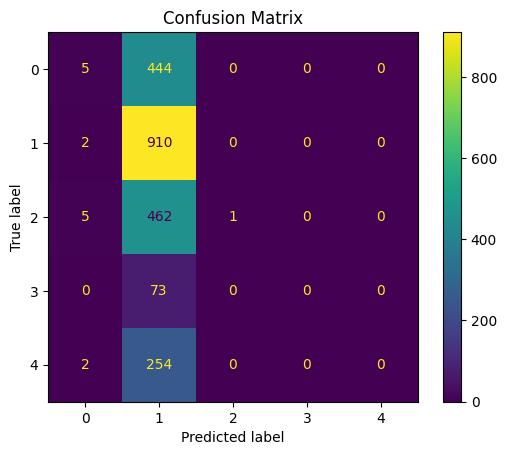

In [89]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred)
plt.title("Confusion Matrix")
plt.show()

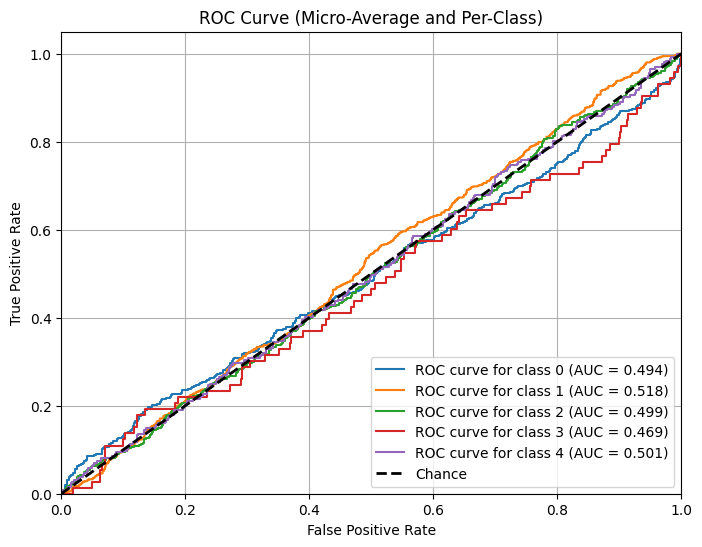

In [90]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test for multiclass (e.g., classes are numbered 0 to n_classes-1)
n_classes = len(np.unique(y_test_encoded))
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))


# Plot ROC for each class
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"ROC curve for class {i} (AUC = {roc_auc[i]:.3f})",
    )

# Plot diagonal
plt.plot([0, 1], [0, 1], "k--", label="Chance", lw=2)

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-Average and Per-Class)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Section 4.2: Resnet

In [62]:
def update_resnet_model(y_train_tensor, num_classes):
    # Load pre-trained ResNet model and modify for single-channel ECG data
    resnet = models.resnet18(pretrained=True)

    # Modify the first convolution layer to accept single channel input
    resnet.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


    # Modify the fully connected layer to match the number of diagnostic classes
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

    return resnet

##### Section 4.2.1 Resnet on raw ECG data

In [63]:
model_resnet = update_resnet_model(y_train_tensor, num_classes)
# Move model to device
model_resnet.to(device)
print(model_resnet)

ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [64]:
print_info_data(y_train_tensor, model_resnet, y_train_encoded, y_test_encoded, X_train_filtered,num_classes)

Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 19230
Length of y_train_encoded: 19230


In [ ]:
training_losses_resnet, accuracies_resnet=train_model(model_resnet, train_loader, device, max_num_epochs)

Epoch [1/40], Loss: 0.8605, Accuracy: 69.49%
Epoch [2/40], Loss: 0.7499, Accuracy: 73.18%
Epoch [3/40], Loss: 0.7013, Accuracy: 74.48%
Epoch [4/40], Loss: 0.6699, Accuracy: 75.36%
Epoch [5/40], Loss: 0.6503, Accuracy: 76.00%
Epoch [6/40], Loss: 0.6316, Accuracy: 77.10%
Epoch [7/40], Loss: 0.6206, Accuracy: 77.19%
Epoch [8/40], Loss: 0.6056, Accuracy: 77.74%
Epoch [9/40], Loss: 0.5917, Accuracy: 78.23%
Epoch [10/40], Loss: 0.5783, Accuracy: 78.66%
Epoch [11/40], Loss: 0.5679, Accuracy: 79.18%
Epoch [12/40], Loss: 0.5558, Accuracy: 79.56%
Epoch [13/40], Loss: 0.5380, Accuracy: 80.43%
Epoch [14/40], Loss: 0.5158, Accuracy: 81.02%
Epoch [15/40], Loss: 0.5017, Accuracy: 81.48%
Epoch [16/40], Loss: 0.4839, Accuracy: 82.02%
Epoch [17/40], Loss: 0.4644, Accuracy: 82.57%
Epoch [18/40], Loss: 0.4380, Accuracy: 83.54%
Epoch [19/40], Loss: 0.4188, Accuracy: 84.17%
Epoch [20/40], Loss: 0.3876, Accuracy: 85.31%
Epoch [21/40], Loss: 0.3451, Accuracy: 87.10%
Epoch [22/40], Loss: 0.3181, Accuracy: 88.0

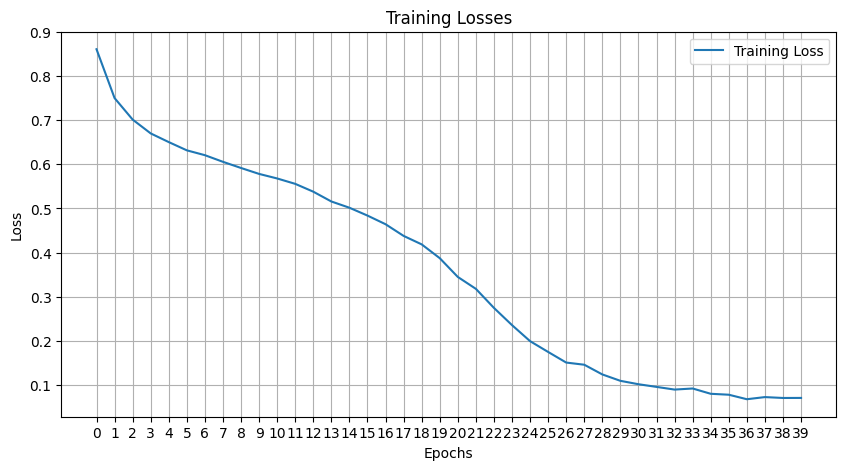

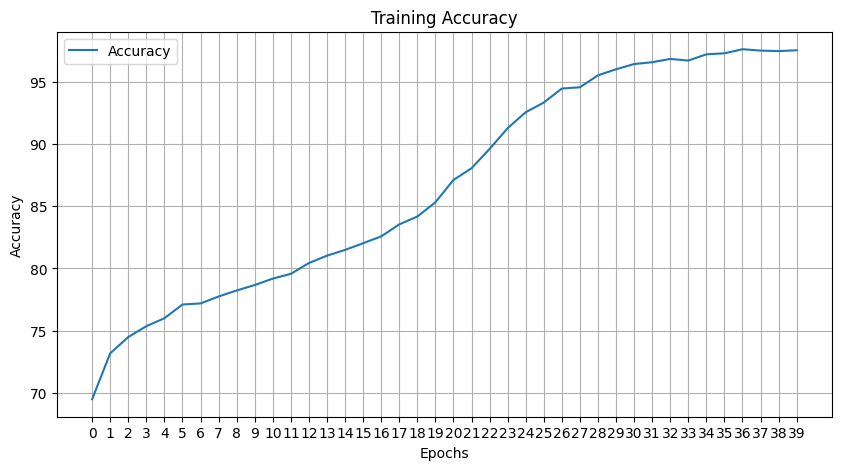

In [66]:
plot_loss_accuracy(training_losses_resnet, accuracies_resnet)

Precision: 0.7322
Recall: 0.7433
F1 Score: 0.7315

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       449
           1       0.78      0.91      0.84       912
           2       0.71      0.72      0.72       468
           3       0.48      0.19      0.27        73
           4       0.60      0.45      0.51       256

    accuracy                           0.74      2158
   macro avg       0.67      0.59      0.61      2158
weighted avg       0.73      0.74      0.73      2158

Test Accuracy: 74.33%


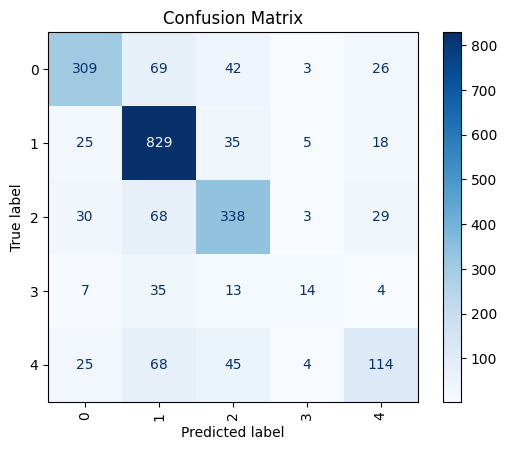

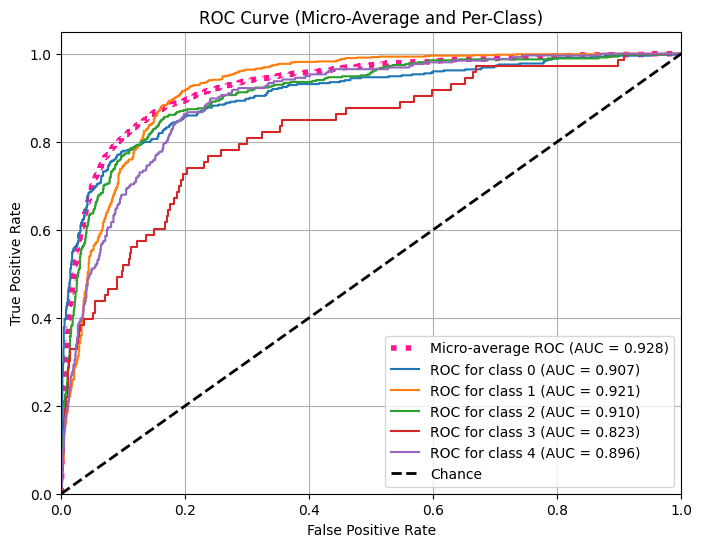

In [92]:
test_model(model_resnet, test_loader, device, num_classes)

##### Section 4.2.2 Resnet with Spectrograms

In [68]:
model_spec = update_resnet_model(y_train_tensor_spec, num_classes)
# Move model to device
model_spec.to(device)
print(model_spec)

ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ece/home/nalla052/CSCI5980/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
print_info_data(y_train_tensor_spec, model_spec, y_train_encoded_spec, y_test_encoded_spec, X_train_filtered_spec, num_classes)

Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 19230
Length of y_train_encoded: 19230


In [ ]:
training_losses_spec, accuracies_spec=train_model(model_spec, train_loader_spec, device, max_num_epochs)

Epoch [1/40], Loss: 1.0392, Accuracy: 61.77%
Epoch [2/40], Loss: 0.9080, Accuracy: 66.95%
Epoch [3/40], Loss: 0.8602, Accuracy: 69.06%
Epoch [4/40], Loss: 0.8381, Accuracy: 69.60%
Epoch [5/40], Loss: 0.7993, Accuracy: 71.11%
Epoch [6/40], Loss: 0.7829, Accuracy: 71.68%
Epoch [7/40], Loss: 0.7592, Accuracy: 72.67%
Epoch [8/40], Loss: 0.7428, Accuracy: 73.31%
Epoch [9/40], Loss: 0.7263, Accuracy: 73.93%
Epoch [10/40], Loss: 0.7096, Accuracy: 74.43%
Epoch [11/40], Loss: 0.6942, Accuracy: 75.03%
Epoch [12/40], Loss: 0.6798, Accuracy: 75.36%
Epoch [13/40], Loss: 0.6563, Accuracy: 75.95%
Epoch [14/40], Loss: 0.6490, Accuracy: 76.51%
Epoch [15/40], Loss: 0.6287, Accuracy: 77.22%
Epoch [16/40], Loss: 0.6112, Accuracy: 77.88%
Epoch [17/40], Loss: 0.5920, Accuracy: 78.86%
Epoch [18/40], Loss: 0.5747, Accuracy: 79.28%
Epoch [19/40], Loss: 0.5461, Accuracy: 80.42%
Epoch [20/40], Loss: 0.5268, Accuracy: 80.96%
Epoch [21/40], Loss: 0.5007, Accuracy: 82.04%
Epoch [22/40], Loss: 0.4774, Accuracy: 82.6

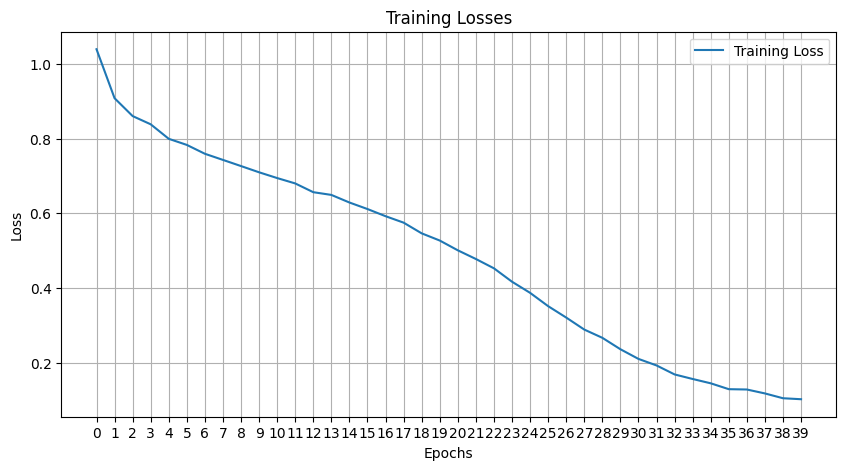

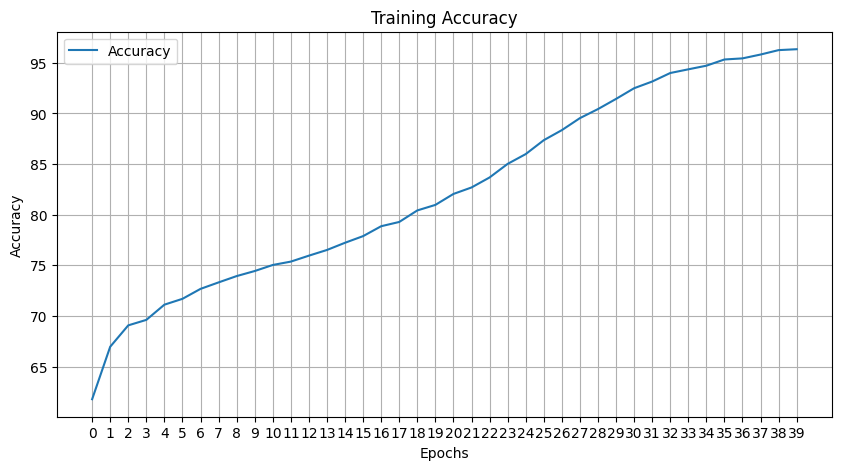

In [71]:
plot_loss_accuracy(training_losses_spec, accuracies_spec)

Precision: 0.6599
Recall: 0.6770
F1 Score: 0.6634

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       449
           1       0.76      0.85      0.80       912
           2       0.61      0.70      0.65       468
           3       0.28      0.15      0.19        73
           4       0.45      0.30      0.36       256

    accuracy                           0.68      2158
   macro avg       0.56      0.52      0.53      2158
weighted avg       0.66      0.68      0.66      2158

Test Accuracy: 67.70%


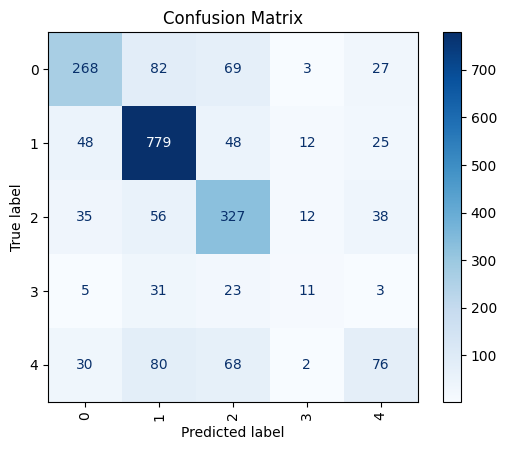

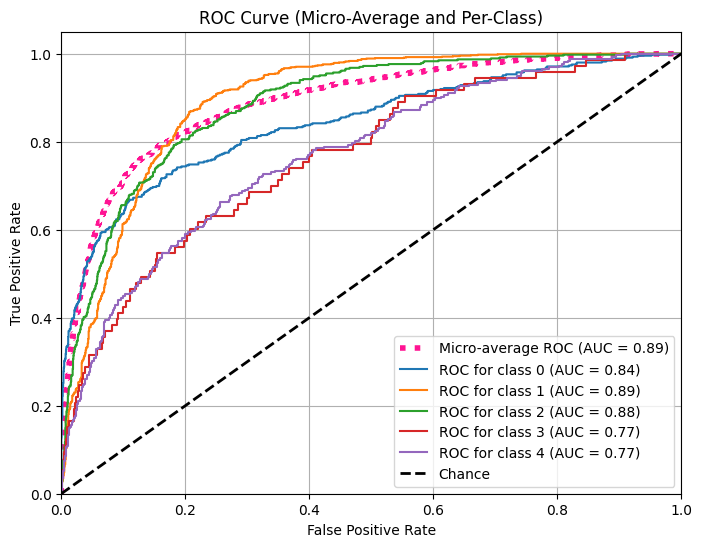

In [72]:
test_model(model_spec, test_loader_spec, device, num_classes)

#### Section 4.3 Resnet 1D - Custom

In [73]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18_1D, self).__init__()

        # Load the pretrained ResNet18 model
        resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to Conv1d (from Conv2d)
        resnet18.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify all Conv2d layers to Conv1d and BatchNorm2d to BatchNorm1d
        self._replace_conv2d_with_conv1d(resnet18)

        # Adjust the average pooling layer to work with 1D
        resnet18.avgpool = nn.AdaptiveAvgPool1d(1)

        # Define the fully connected layer (fc) to match the number of output classes
        resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

        # Store the modified ResNet18 model
        self.resnet18 = resnet18

    def _replace_conv2d_with_conv1d(self, model):
        """Recursively replace Conv2d with Conv1d and BatchNorm2d with BatchNorm1d in all layers of the ResNet18 model."""
        for name, module in model.named_children():
            if isinstance(module, nn.Conv2d):
                # Replace Conv2d with Conv1d
                in_channels = module.in_channels
                out_channels = module.out_channels
                kernel_size = module.kernel_size[0]  # Get the kernel size for 1D
                stride = module.stride[0]  # Get the stride for 1D
                padding = module.padding[0]  # Get the padding for 1D

                # Create new Conv1d layer
                new_conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
                setattr(model, name, new_conv)

            elif isinstance(module, nn.BatchNorm2d):
                # Replace BatchNorm2d with BatchNorm1d
                num_features = module.num_features
                new_bn = nn.BatchNorm1d(num_features)
                setattr(model, name, new_bn)

            elif isinstance(module, nn.MaxPool2d):
                # Replace MaxPool2d with MaxPool1d
                kernel_size = module.kernel_size  
                stride = module.stride 
                padding = module.padding  

                # Create new MaxPool1d layer
                new_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
                setattr(model, name, new_pool)

            # Recursively handle Sequential and ModuleList containers
            elif isinstance(module, nn.Sequential):
                self._replace_conv2d_with_conv1d(module)
            elif isinstance(module, nn.ModuleList):
                for m in module:
                    self._replace_conv2d_with_conv1d(m)
            elif isinstance(module, nn.Module):
                self._replace_conv2d_with_conv1d(module)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [74]:
model_1d = ResNet18_1D(num_classes)
# Move model to device
model_1d.to(device)
print(model_1d)

ResNet18_1D(
  (resnet18): ResNet(
    (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
training_losses_1d, accuracies_1d=train_model(model_1d, train_loader_clean_1d, device, max_num_epochs)

Epoch [1/40], Loss: 0.8837, Accuracy: 68.22%
Epoch [2/40], Loss: 0.7695, Accuracy: 72.48%
Epoch [3/40], Loss: 0.7194, Accuracy: 74.11%
Epoch [4/40], Loss: 0.6928, Accuracy: 74.94%
Epoch [5/40], Loss: 0.6773, Accuracy: 75.48%
Epoch [6/40], Loss: 0.6540, Accuracy: 76.12%
Epoch [7/40], Loss: 0.6403, Accuracy: 76.70%
Epoch [8/40], Loss: 0.6296, Accuracy: 77.01%
Epoch [9/40], Loss: 0.6158, Accuracy: 77.62%
Epoch [10/40], Loss: 0.6063, Accuracy: 77.54%
Epoch [11/40], Loss: 0.5969, Accuracy: 78.14%
Epoch [12/40], Loss: 0.5891, Accuracy: 78.25%
Epoch [13/40], Loss: 0.5752, Accuracy: 78.70%
Epoch [14/40], Loss: 0.5675, Accuracy: 78.90%
Epoch [15/40], Loss: 0.5626, Accuracy: 79.06%
Epoch [16/40], Loss: 0.5519, Accuracy: 79.69%
Epoch [17/40], Loss: 0.5407, Accuracy: 79.93%
Epoch [18/40], Loss: 0.5339, Accuracy: 80.60%
Epoch [19/40], Loss: 0.5223, Accuracy: 80.89%
Epoch [20/40], Loss: 0.5117, Accuracy: 80.81%
Epoch [21/40], Loss: 0.5013, Accuracy: 81.29%
Epoch [22/40], Loss: 0.4916, Accuracy: 81.7

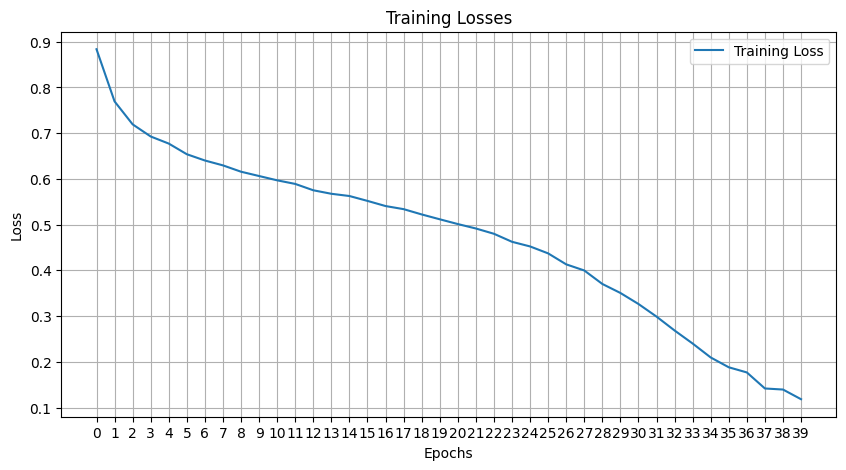

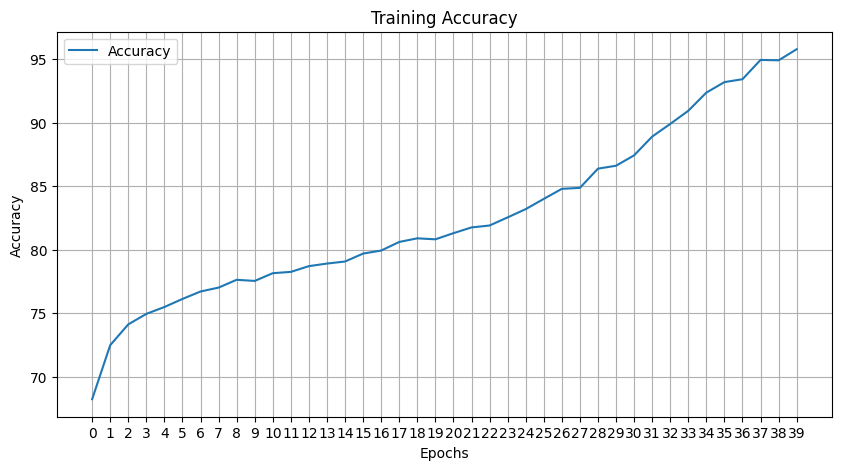

In [76]:
plot_loss_accuracy(training_losses_1d, accuracies_1d)

Precision: 0.7263
Recall: 0.7391
F1 Score: 0.7286

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       449
           1       0.78      0.91      0.84       912
           2       0.73      0.68      0.71       468
           3       0.33      0.18      0.23        73
           4       0.58      0.46      0.52       256

    accuracy                           0.74      2158
   macro avg       0.64      0.59      0.60      2158
weighted avg       0.73      0.74      0.73      2158

Test Accuracy: 73.91%


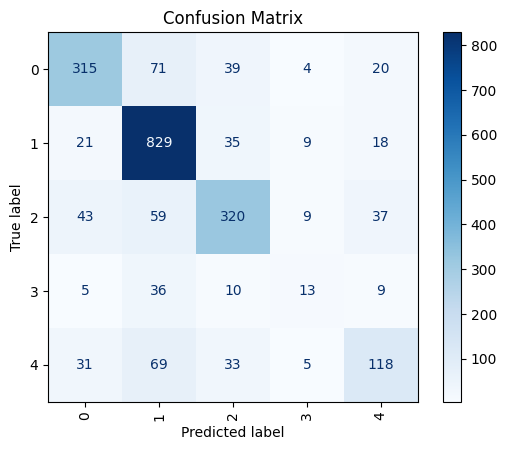

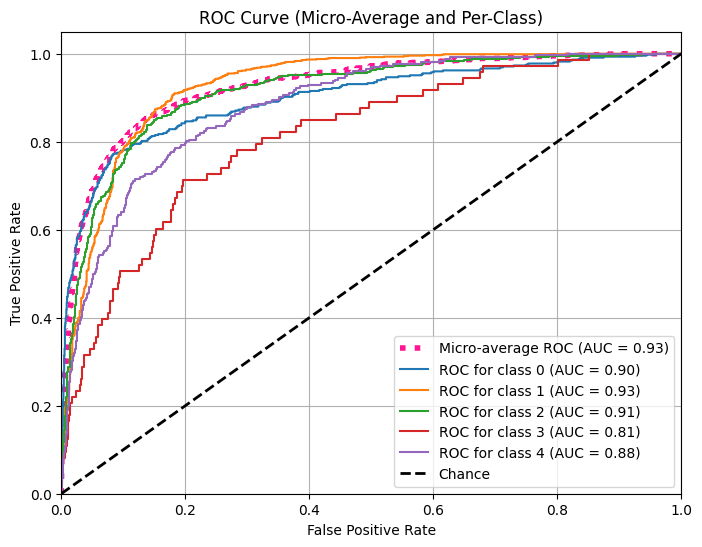

In [77]:
test_model(model_1d, test_loader_clean_1d, device, num_classes)

#### Section 4.4 Resnet1D

In [78]:
from models.resnet1d import resnet1d18

model1d=resnet1d18(input_channels=12, num_classes=num_classes, kernel_size=[3,3])
model1d.to(device)
print(model1d)

ResNet1d(
  (0): Conv1d(12, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock1d(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_si

In [ ]:
training_losses1d, accuracies1d=train_model(model1d, train_loader_1d, device, max_num_epochs)

Epoch [1/40], Loss: 0.9424, Accuracy: 66.28%
Epoch [2/40], Loss: 0.7924, Accuracy: 71.95%
Epoch [3/40], Loss: 0.7470, Accuracy: 73.27%
Epoch [4/40], Loss: 0.7172, Accuracy: 74.36%
Epoch [5/40], Loss: 0.7067, Accuracy: 74.79%
Epoch [6/40], Loss: 0.6917, Accuracy: 75.11%
Epoch [7/40], Loss: 0.6792, Accuracy: 75.59%
Epoch [8/40], Loss: 0.6758, Accuracy: 75.81%
Epoch [9/40], Loss: 0.6599, Accuracy: 76.01%
Epoch [10/40], Loss: 0.6560, Accuracy: 76.28%
Epoch [11/40], Loss: 0.6425, Accuracy: 76.87%
Epoch [12/40], Loss: 0.6366, Accuracy: 77.06%
Epoch [13/40], Loss: 0.6320, Accuracy: 77.29%
Epoch [14/40], Loss: 0.6236, Accuracy: 77.27%
Epoch [15/40], Loss: 0.6169, Accuracy: 77.84%
Epoch [16/40], Loss: 0.6122, Accuracy: 77.74%
Epoch [17/40], Loss: 0.6035, Accuracy: 78.40%
Epoch [18/40], Loss: 0.5947, Accuracy: 78.32%
Epoch [19/40], Loss: 0.5893, Accuracy: 78.77%
Epoch [20/40], Loss: 0.5833, Accuracy: 78.99%
Epoch [21/40], Loss: 0.5639, Accuracy: 79.40%
Epoch [22/40], Loss: 0.5618, Accuracy: 79.5

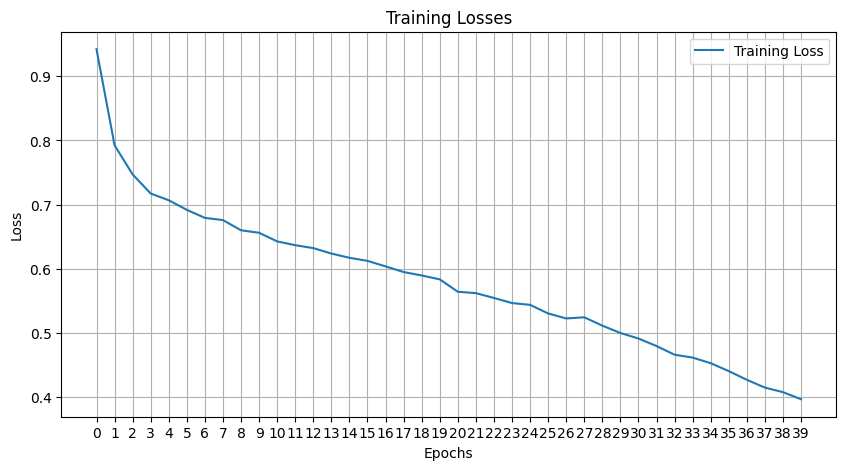

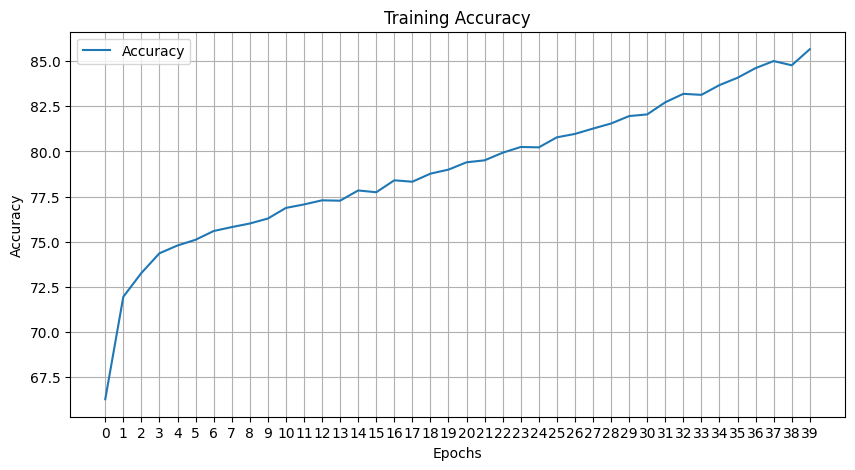

In [80]:
plot_loss_accuracy(training_losses1d, accuracies1d)

Precision: 0.7271
Recall: 0.7363
F1 Score: 0.7265

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       449
           1       0.77      0.90      0.83       912
           2       0.72      0.75      0.73       468
           3       0.43      0.26      0.32        73
           4       0.57      0.44      0.50       256

    accuracy                           0.74      2158
   macro avg       0.65      0.60      0.62      2158
weighted avg       0.73      0.74      0.73      2158

Test Accuracy: 73.63%


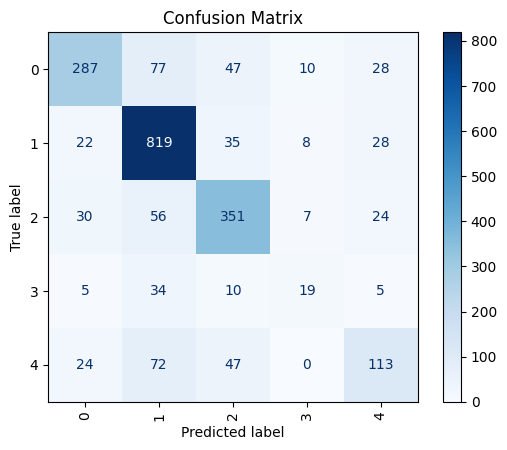

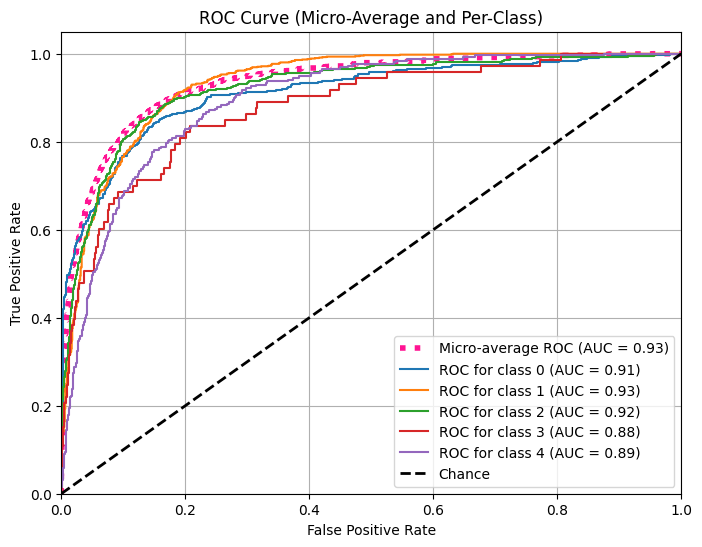

In [81]:
test_model(model1d, test_loader_1d, device, num_classes)

#### Section 4.5 xResnet

In [101]:
from models.xresnet1d import xresnet1d101

model_xres_1d=xresnet1d101(input_channels=12, num_classes=num_classes)
model_xres_1d.to(device)
print(model_xres_1d)

XResNet1d(
  (0): ConvLayer(
    (0): Conv1d(12, 32, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): ConvLayer(
          (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
    

In [102]:
training_losses_xres_1d, accuracies_xres_1d=train_model(model_xres_1d, train_loader_1d, device, max_num_epochs)

Epoch [1/40], Loss: 1.1601, Accuracy: 62.12%
Epoch [2/40], Loss: 0.8833, Accuracy: 69.17%
Epoch [3/40], Loss: 0.7909, Accuracy: 71.73%
Epoch [4/40], Loss: 0.7584, Accuracy: 72.77%
Epoch [5/40], Loss: 0.7276, Accuracy: 73.65%
Epoch [6/40], Loss: 0.7159, Accuracy: 74.15%
Epoch [7/40], Loss: 0.7025, Accuracy: 74.76%
Epoch [8/40], Loss: 0.6916, Accuracy: 75.03%
Epoch [9/40], Loss: 0.6794, Accuracy: 75.48%
Epoch [10/40], Loss: 0.6644, Accuracy: 75.93%
Epoch [11/40], Loss: 0.6530, Accuracy: 76.50%
Epoch [12/40], Loss: 0.6516, Accuracy: 76.45%
Epoch [13/40], Loss: 0.6326, Accuracy: 77.19%
Epoch [14/40], Loss: 0.6268, Accuracy: 77.16%
Epoch [15/40], Loss: 0.6177, Accuracy: 77.41%
Epoch [16/40], Loss: 0.6033, Accuracy: 77.96%
Epoch [17/40], Loss: 0.5964, Accuracy: 78.12%
Epoch [18/40], Loss: 0.5948, Accuracy: 78.33%
Epoch [19/40], Loss: 0.5809, Accuracy: 78.60%
Epoch [20/40], Loss: 0.5692, Accuracy: 79.50%
Epoch [21/40], Loss: 0.5704, Accuracy: 79.22%
Epoch [22/40], Loss: 0.5479, Accuracy: 79.7

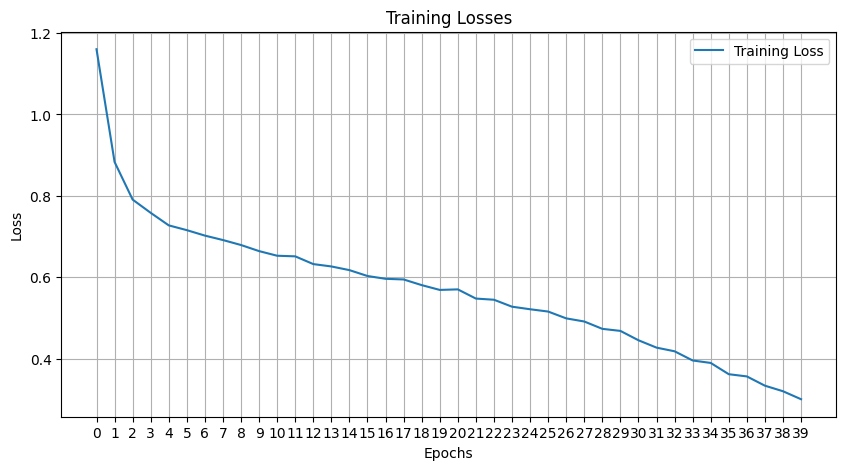

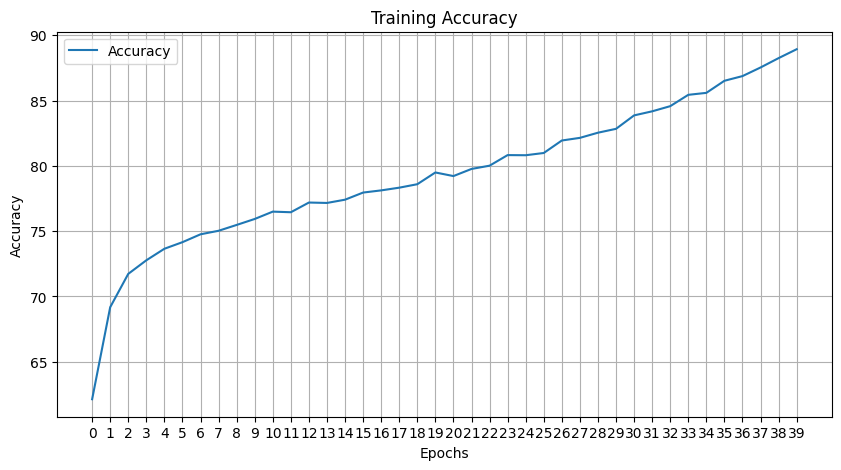

In [103]:
plot_loss_accuracy(training_losses_xres_1d, accuracies_xres_1d)

Precision: 0.7244
Recall: 0.7326
F1 Score: 0.7245

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       449
           1       0.78      0.90      0.84       912
           2       0.73      0.67      0.70       468
           3       0.38      0.21      0.27        73
           4       0.55      0.55      0.55       256

    accuracy                           0.73      2158
   macro avg       0.64      0.59      0.61      2158
weighted avg       0.72      0.73      0.72      2158

Test Accuracy: 73.26%


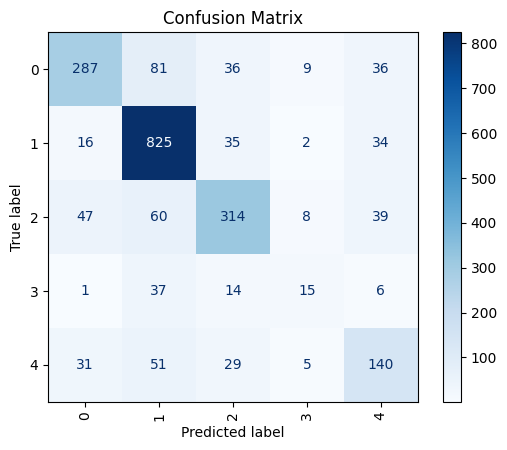

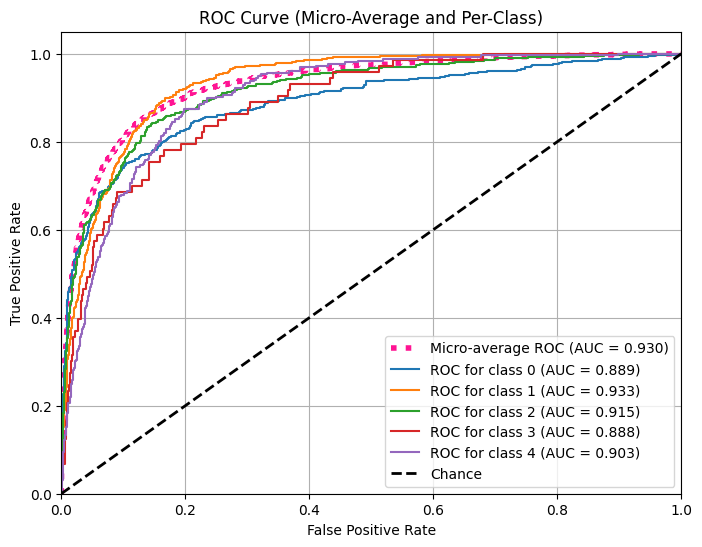

In [104]:
test_model(model_xres_1d, test_loader_1d, device, num_classes)

#### Section 4.6 Inception1d

In [84]:
from models.inception1d import inception1d

model_incep_1d=inception1d(input_channels=12, num_classes=num_classes)
model_incep_1d.to(device)
print(model_incep_1d)

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [85]:
training_losses_incep_1d, accuracies_incep_1d=train_model(model_incep_1d, train_loader_1d, device, max_num_epochs)

Epoch [1/40], Loss: 0.9415, Accuracy: 66.05%
Epoch [2/40], Loss: 0.8083, Accuracy: 71.15%
Epoch [3/40], Loss: 0.7703, Accuracy: 72.54%
Epoch [4/40], Loss: 0.7462, Accuracy: 73.24%
Epoch [5/40], Loss: 0.7367, Accuracy: 73.44%
Epoch [6/40], Loss: 0.7194, Accuracy: 74.14%
Epoch [7/40], Loss: 0.7093, Accuracy: 74.71%
Epoch [8/40], Loss: 0.6989, Accuracy: 74.74%
Epoch [9/40], Loss: 0.6878, Accuracy: 75.25%
Epoch [10/40], Loss: 0.6738, Accuracy: 75.94%
Epoch [11/40], Loss: 0.6746, Accuracy: 75.67%
Epoch [12/40], Loss: 0.6686, Accuracy: 75.88%
Epoch [13/40], Loss: 0.6603, Accuracy: 76.32%
Epoch [14/40], Loss: 0.6495, Accuracy: 76.46%
Epoch [15/40], Loss: 0.6461, Accuracy: 76.63%
Epoch [16/40], Loss: 0.6392, Accuracy: 77.11%
Epoch [17/40], Loss: 0.6307, Accuracy: 77.22%
Epoch [18/40], Loss: 0.6331, Accuracy: 77.35%
Epoch [19/40], Loss: 0.6214, Accuracy: 77.69%
Epoch [20/40], Loss: 0.6173, Accuracy: 77.90%
Epoch [21/40], Loss: 0.6065, Accuracy: 77.95%
Epoch [22/40], Loss: 0.6027, Accuracy: 78.1

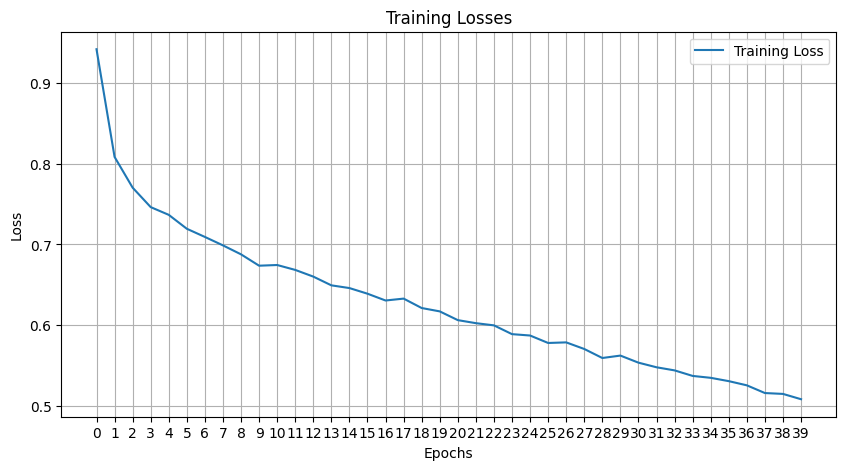

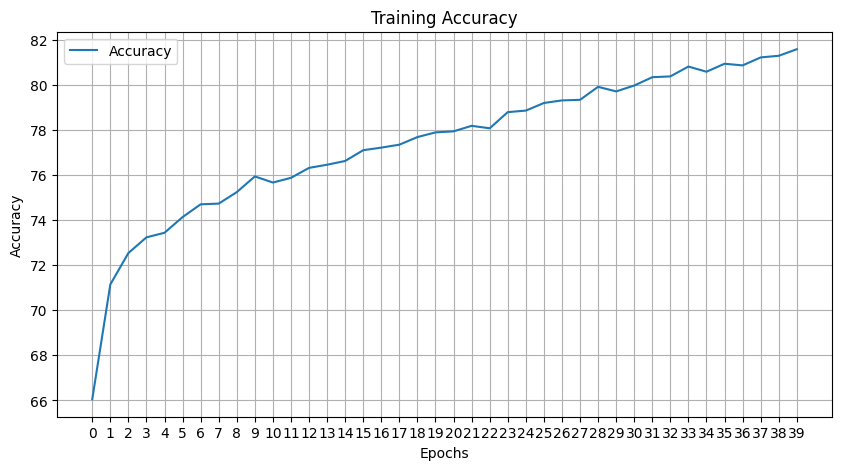

In [86]:
plot_loss_accuracy(training_losses_incep_1d, accuracies_incep_1d)

Precision: 0.7395
Recall: 0.7479
F1 Score: 0.7358

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       449
           1       0.79      0.91      0.85       912
           2       0.71      0.78      0.74       468
           3       0.58      0.19      0.29        73
           4       0.58      0.46      0.51       256

    accuracy                           0.75      2158
   macro avg       0.69      0.60      0.62      2158
weighted avg       0.74      0.75      0.74      2158

Test Accuracy: 74.79%


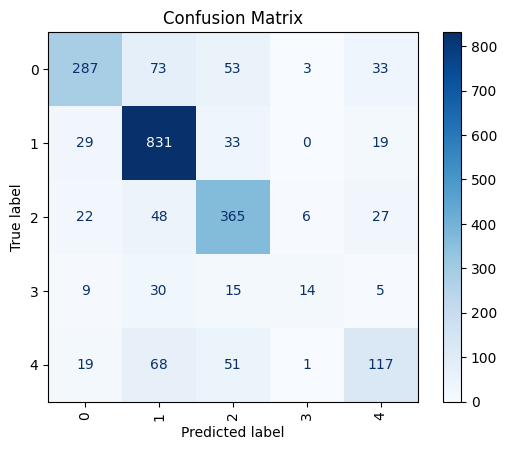

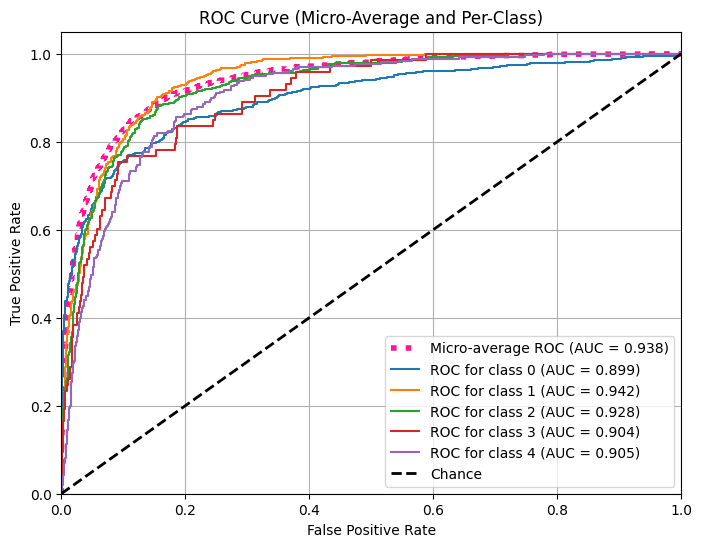

In [93]:
test_model(model_incep_1d, test_loader_1d, device, num_classes)